Сталь – один из важнейших строительных материалов современности. Стальные здания устойчивы к естественному и искусственному износу, что сделало этот материал повсеместно распространенным во всем мире. Чтобы сделать производство стали более эффективным, этот конкурс поможет выявить дефекты.


ссылка на каггл с этим соревнованием - https://www.kaggle.com/c/severstal-steel-defect-detection

### Постановка задачи :

Этот конкурс представляет собой двойной конкурс: классифицируйте тип дефекта стали, а также сегментируйте части изображения, содержащие дефект.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout

2024-02-19 22:16:48.610631: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-19 22:16:48.610746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-19 22:16:48.770390: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')

In [3]:
data

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...
...,...,...,...
7090,ffcf72ecf.jpg,3,121911 34 122167 101 122422 169 122678 203 122...
7091,fff02e9c5.jpg,3,207523 3 207777 9 208030 15 208283 22 208537 2...
7092,fffe98443.jpg,3,105929 5 106177 14 106424 24 106672 33 106923 ...
7093,ffff4eaa8.jpg,3,16899 7 17155 20 17411 34 17667 47 17923 60 18...


In [4]:
data.shape

(7095, 3)

У нас 7095 и три фичи

# Разведочный анализ данных

ClassId
3    5150
1     897
4     801
2     247
Name: count, dtype: int64

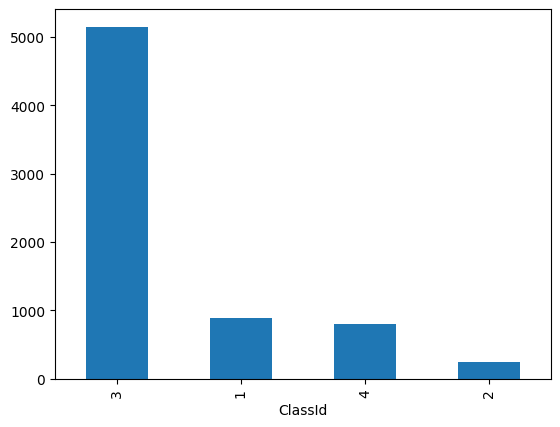

In [5]:
data["ClassId"].value_counts().plot(kind = 'bar')
data["ClassId"].value_counts()

больше всего меток третьего класса

Перекос данных, поэтому выполним аугментацию.

In [6]:
import cv2

In [7]:
l1=[]
l2=[]
for img,ClassId,EncodedPixels in tqdm(data.values):
    image=cv2.imread("/kaggle/input/severstal-steel-defect-detection/train_images/{}".format(img),cv2.IMREAD_COLOR)
    image=cv2.resize(image,(120,120))
    l1.append(image)
    l2.append(ClassId)

100%|██████████| 7095/7095 [01:51<00:00, 63.72it/s]


Проверка изображений случайной стали, чтобы проверить, дефектна ли она или нет.

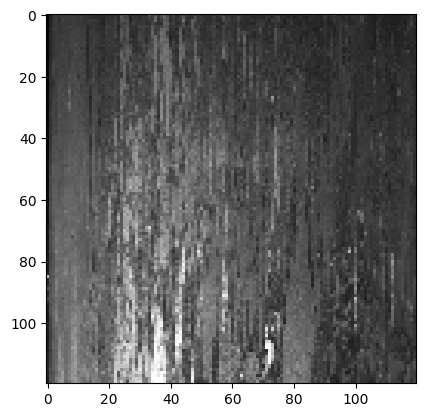

In [8]:
i = 15
plt.imshow(l1[i])

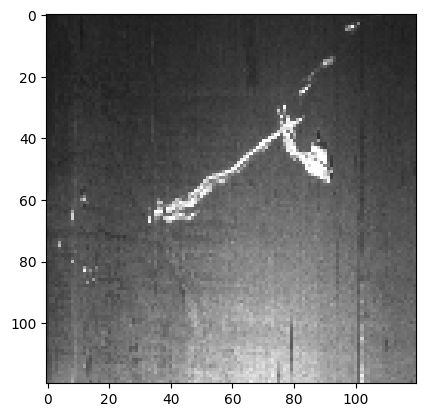

In [9]:
i = 16
plt.imshow(l1[i])

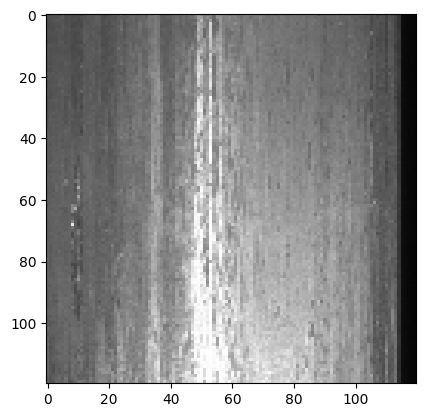

In [10]:
i = 90
plt.imshow(l1[i])

Выполним one-hot кодировку

In [11]:
encoder = LabelEncoder()

X= np.array(l1)
X = X/255

y = encoder.fit_transform(l2)
y = np.array(y)

In [12]:
X.shape

(7095, 120, 120, 3)

In [13]:
y.shape

(7095,)

# Борьба с дибалансом

для борьбы с дисбалансом выполним случайное сэмплирование

In [14]:
from imblearn.over_sampling import RandomOverSampler

reshaped_X = X.reshape(X.shape[0],-1)
oversample = RandomOverSampler(sampling_strategy='not majority')
X, y  = oversample.fit_resample(reshaped_X , y)

X = X[:10000]
y = y[:10000]

X = X.reshape(-1,120,120,3)

In [15]:
X.shape

(10000, 120, 120, 3)

In [16]:
y_cat = to_categorical(y)

разделим на тренировку и валидацию

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y_cat,test_size=0.2,stratify=y_cat,shuffle=True)

In [18]:
print("x_train размер:",X_train.shape)
print("x_test размер:",X_test.shape)
print("y_train размер:",y_train.shape)
print("y_test размер:",y_test.shape)

x_train размер: (8000, 120, 120, 3)
x_test размер: (2000, 120, 120, 3)
y_train размер: (8000, 4)
y_test размер: (2000, 4)


# Построение нейронной сети  в 3 слоя и график обучения

In [19]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(Flatten())
model.add(Dense(4,activation="softmax"))

In [20]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test), batch_size=128, verbose=1)

Epoch 1/10
63/63 [==============================] - 24s 367ms/step - loss: 3.6335 - accuracy: 0.5232 - val_loss: 0.8913 - val_accuracy: 0.6035
Epoch 2/10
63/63 [==============================] - 22s 349ms/step - loss: 0.7924 - accuracy: 0.6319 - val_loss: 0.7275 - val_accuracy: 0.6705
Epoch 3/10
63/63 [==============================] - 23s 367ms/step - loss: 0.6568 - accuracy: 0.7210 - val_loss: 0.6424 - val_accuracy: 0.7715
Epoch 4/10
63/63 [==============================] - 24s 385ms/step - loss: 0.5508 - accuracy: 0.7928 - val_loss: 0.5839 - val_accuracy: 0.7855
Epoch 5/10
63/63 [==============================] - 23s 371ms/step - loss: 0.4675 - accuracy: 0.8322 - val_loss: 0.5556 - val_accuracy: 0.8055
Epoch 6/10
63/63 [==============================] - 28s 450ms/step - loss: 0.3939 - accuracy: 0.8710 - val_loss: 0.5364 - val_accuracy: 0.8165
Epoch 7/10
63/63 [==============================] - 34s 535ms/step - loss: 0.3417 - accuracy: 0.8861 - val_loss: 0.5254 - val_accuracy: 0.8260

<Axes: title={'center': 'Loss curve'}>

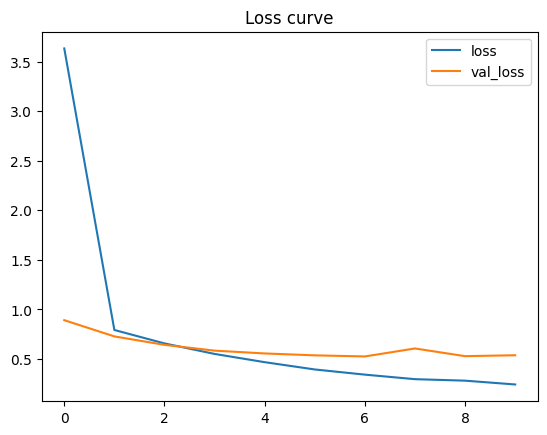

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve 0.92'}>

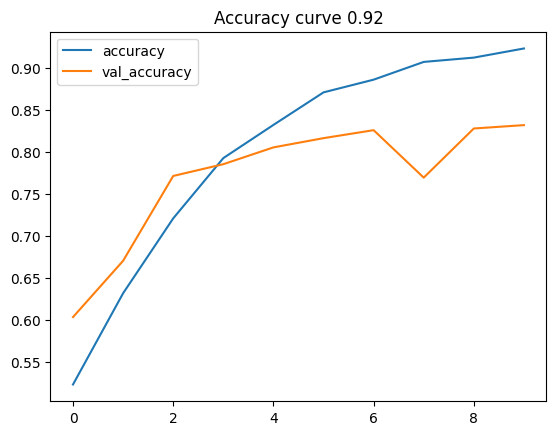

In [23]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = f'Accuracy curve {round(max(history_df["accuracy"]), 2)}')

# Построение нейронной сети  в 5 слоев

In [24]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(256,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [25]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [26]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test), batch_size=128, verbose=1)

Epoch 1/10
63/63 [==============================] - 33s 508ms/step - loss: 1.9702 - accuracy: 0.5479 - val_loss: 0.7890 - val_accuracy: 0.6290
Epoch 2/10
63/63 [==============================] - 31s 489ms/step - loss: 0.7375 - accuracy: 0.6823 - val_loss: 0.6628 - val_accuracy: 0.7445
Epoch 3/10
63/63 [==============================] - 31s 493ms/step - loss: 0.6450 - accuracy: 0.7315 - val_loss: 0.6094 - val_accuracy: 0.7830
Epoch 4/10
63/63 [==============================] - 31s 490ms/step - loss: 0.5786 - accuracy: 0.7799 - val_loss: 0.5929 - val_accuracy: 0.7530
Epoch 5/10
63/63 [==============================] - 31s 492ms/step - loss: 0.5225 - accuracy: 0.8037 - val_loss: 0.5304 - val_accuracy: 0.7935
Epoch 6/10
63/63 [==============================] - 31s 493ms/step - loss: 0.4783 - accuracy: 0.8226 - val_loss: 0.5018 - val_accuracy: 0.8020
Epoch 7/10
63/63 [==============================] - 31s 498ms/step - loss: 0.4329 - accuracy: 0.8401 - val_loss: 0.4882 - val_accuracy: 0.8235

<Axes: title={'center': 'Loss curve'}>

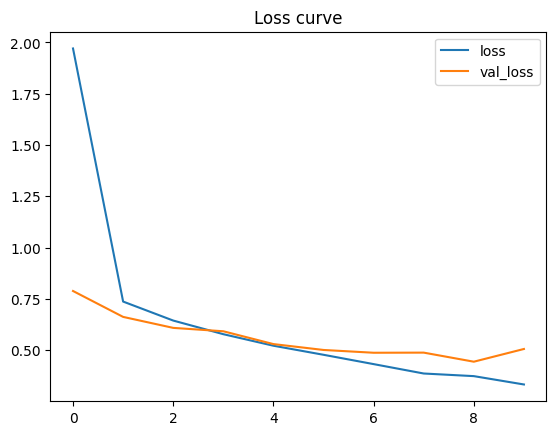

In [27]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve 0.88'}>

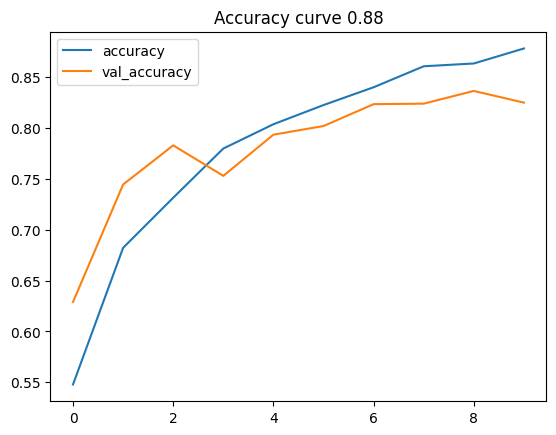

In [28]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = f'Accuracy curve {round(max(history_df["accuracy"]), 2)}')

# Построение нейронной сети в 13 слоев и обучение

In [29]:
model=Sequential()
model.add(Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(64,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32,activation="relu"))
model.add(Dense(4,activation="softmax"))

In [30]:
# early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

Сборка и обучение модели

In [31]:
model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(),
             metrics=["accuracy"])

In [32]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test,y_test), batch_size=128, verbose=1)

Epoch 1/10
63/63 [==============================] - 41s 633ms/step - loss: 1.0366 - accuracy: 0.5166 - val_loss: 0.9150 - val_accuracy: 0.5885
Epoch 2/10
63/63 [==============================] - 39s 626ms/step - loss: 0.9156 - accuracy: 0.5826 - val_loss: 0.8813 - val_accuracy: 0.5920
Epoch 3/10
63/63 [==============================] - 40s 628ms/step - loss: 0.8589 - accuracy: 0.6004 - val_loss: 0.7880 - val_accuracy: 0.6470
Epoch 4/10
63/63 [==============================] - 39s 619ms/step - loss: 0.7964 - accuracy: 0.6277 - val_loss: 0.8180 - val_accuracy: 0.5955
Epoch 5/10
63/63 [==============================] - 52s 823ms/step - loss: 0.7702 - accuracy: 0.6436 - val_loss: 0.7159 - val_accuracy: 0.6845
Epoch 6/10
63/63 [==============================] - 40s 642ms/step - loss: 0.7403 - accuracy: 0.6618 - val_loss: 0.7148 - val_accuracy: 0.6700
Epoch 7/10
63/63 [==============================] - 40s 631ms/step - loss: 0.7050 - accuracy: 0.6858 - val_loss: 0.6600 - val_accuracy: 0.7100

# Анализ результатов обучения

<Axes: title={'center': 'Loss curve'}>

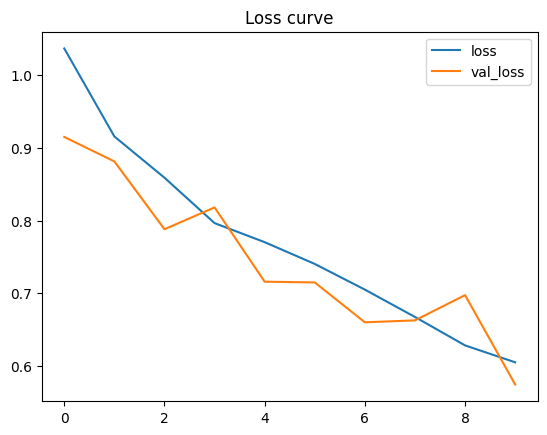

In [33]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title = 'Loss curve')

<Axes: title={'center': 'Accuracy curve 0.74'}>

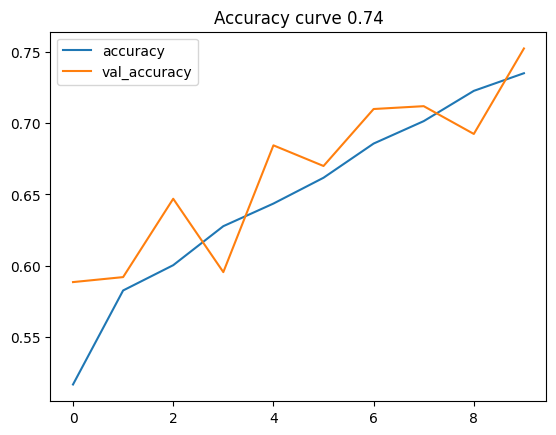

In [34]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = f'Accuracy curve {round(max(history_df["accuracy"]), 2)}')

In [35]:
loss, accuracy = model.evaluate(X_test, y_test)

print(f"[+] Accuracy: {accuracy*100:.2f}%")

63/63 [==============================] - 4s 57ms/step - loss: 0.5745 - accuracy: 0.7525
[+] Accuracy: 75.25%


In [36]:
from keras.models import Model
model.save('my_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
from keras.models import load_model

loaded_model = load_model('my_model.h5')


# Архитектура созданной нейронной сети

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 128)        

# Тестирование на новых примерах

In [39]:
l2[:3]

[1, 3, 1]

In [40]:
X= np.array(l1[:3])
X = X/255

y = encoder.fit_transform(l2[:3])
y = np.array(y)

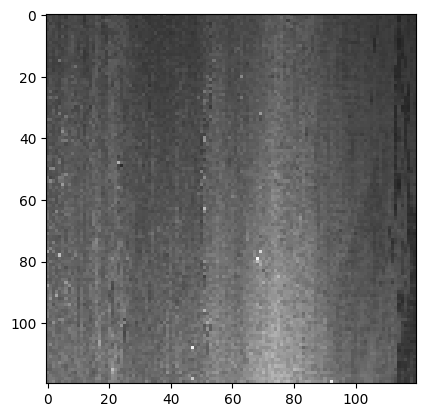

In [41]:
plt.imshow(l1[0]);

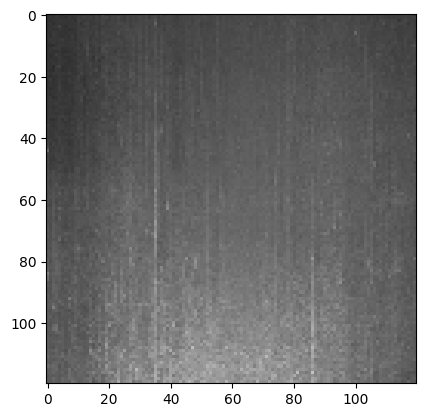

In [42]:
plt.imshow(l1[1]);

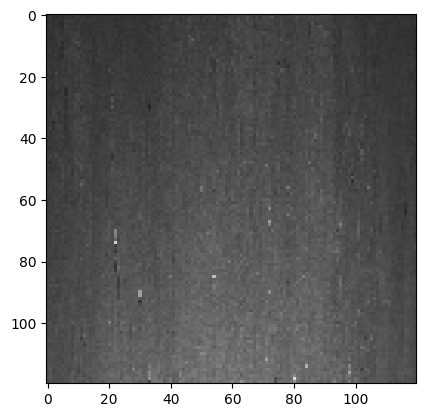

In [43]:
plt.imshow(l1[2]);

In [44]:
y_cat =  to_categorical(y)
y_cat

array([[1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [45]:
predictions = model.predict(X)
predictions

1/1 [==============================] - 0s 131ms/step


array([[0.62177914, 0.00158261, 0.367331  , 0.00930728],
       [0.5081338 , 0.00462499, 0.45464966, 0.03259151],
       [0.547706  , 0.00491434, 0.4048033 , 0.04257634]], dtype=float32)

Здесь три эксперимента, где мы видим, что тест № 2 был с меткой 3, но неверно идентифицировался как метка 1.

In [46]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 10, 10, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 128)        

# описание архитектуры нейронной сети

У нас тут многослойная нейронная сеть с разными типами слоев.

теперь по поводу слоев нейронной сети и их особенностей.

1 слой - Conv2D. Он используется для выполнения двумерной свертки входных данных. Он применяет набор фильтров к входному изображению или карте объектов, перемещая их по входным данным и вычисляя скалярное произведение в каждом месте. Эта операция позволяет слою извлекать объекты и фиксировать пространственные отношения во входных данных. Уровень Conv2D обычно используется в сверточных нейронных сетях (CNN) для таких задач, как классификация изображений, обнаружение объектов и сегментация изображений.

2 слой - MaxPooling2D.  Это  операция понижающей дискретизации, которая уменьшает пространственные размеры (ширину и высоту) входного изображения или карты объектов. Он делит входные данные на непересекающиеся прямоугольники и выводит максимальное значение внутри каждого прямоугольника. Это помогает извлечь наиболее важные функции и снизить вычислительные требования для последующих слоев.

Далее эти слои повторяются еще 2 раза.

7 слой - Flatten. он преобразует входной тензор в одномерный массив, эффективно выравнивая его. Он принимает многомерный входной тензор, например двумерное изображение, и преобразует его в одномерный вектор, который можно использовать в качестве входных данных для полностью связного слоя или любого другого слоя, который ожидает одномерных входных данных.

8 слой - Dense. это полностью связный слой, который соединяет каждый нейрон предыдущего слоя с каждым нейроном текущего слоя. Он выполняет линейную операцию над входными данными, за которой следует функция активации, позволяющая сети изучать сложные закономерности и взаимосвязи в данных. Количество нейронов в плотном слое определяет размерность вывода.

9 cлой - Dropout. это метод регуляризации, используемый для уменьшения переобучения в нейронных сетях. Он случайным образом устанавливает для части входных единиц значение 0 на каждом этапе обучения, что помогает предотвратить слишком большую зависимость сети от конкретных функций или корреляций. Dropout улучшает способность модели к обобщению за счет внесения шума во время обучения и побуждает сеть изучать более надежные и независимые представления.

Далее слои повторяются.

В итоге в данной нейронной сети 12 различных слоев, и 139 780 параметров.

пробуем обучить две отдельных сети, возможно ансамбль добьется большего?

In [47]:
models = dict()
models[0] = [keras.Sequential([
    keras.layers.Conv2D(32,(3,3),input_shape=(120,120,3),activation="relu"),
    keras.layers.MaxPooling2D(pool_size=(3,3)),    
    keras.layers.Flatten(input_shape=(120,120,3)),    
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation="softmax")
]), tf.keras.optimizers.Adam(learning_rate=0.001), 250]
models[1] = [keras.Sequential([
    keras.layers.Flatten(input_shape=(120,120,3)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='gelu'),
    keras.layers.Dense(32, activation='sigmoid'),    
    keras.layers.Dense(4, activation="softmax")
]), tf.keras.optimizers.AdamW(learning_rate=0.001), 450]

for key, param in models.items():
    model, opt, batch = param[0], param[1], param[2]
      
    model.compile(optimizer = opt, loss = tf.keras.losses.categorical_crossentropy, metrics=["accuracy"])
    history = model.fit(X_train, y_train, batch_size = batch, epochs = 10, verbose = 1, validation_data = (X_test, y_test) )        
    
    np.save(f'history{key}.npy', history.history)

Epoch 1/10
32/32 [==============================] - 32s 968ms/step - loss: 1.1741 - accuracy: 0.4944 - val_loss: 0.9175 - val_accuracy: 0.5935
Epoch 2/10
32/32 [==============================] - 31s 975ms/step - loss: 0.8921 - accuracy: 0.5816 - val_loss: 0.7726 - val_accuracy: 0.6690
Epoch 3/10
32/32 [==============================] - 28s 879ms/step - loss: 0.7867 - accuracy: 0.6348 - val_loss: 0.7077 - val_accuracy: 0.7015
Epoch 4/10
32/32 [==============================] - 28s 863ms/step - loss: 0.7072 - accuracy: 0.6875 - val_loss: 0.6170 - val_accuracy: 0.7445
Epoch 5/10
32/32 [==============================] - 28s 865ms/step - loss: 0.6431 - accuracy: 0.7283 - val_loss: 0.5673 - val_accuracy: 0.7720
Epoch 6/10
32/32 [==============================] - 29s 914ms/step - loss: 0.5646 - accuracy: 0.7782 - val_loss: 0.4995 - val_accuracy: 0.8095
Epoch 7/10
32/32 [==============================] - 29s 906ms/step - loss: 0.5127 - accuracy: 0.7955 - val_loss: 0.5392 - val_accuracy: 0.7855

<Axes: title={'center': 'Accuracy curve 0.73'}>

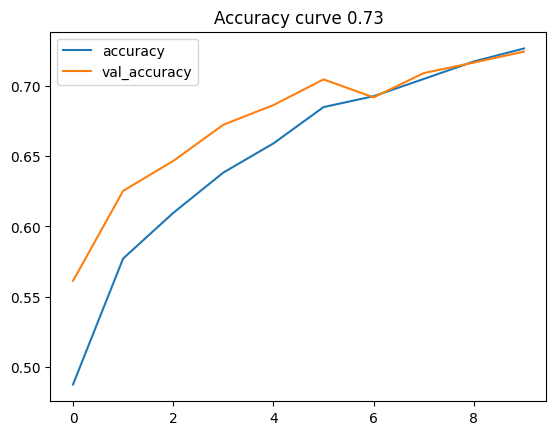

In [48]:
history_df = None

for index in range(len(models)):
    history = np.load(f'history{index}.npy',allow_pickle='TRUE').item()        
    history_df = pd.concat([history_df, pd.DataFrame(history)])

history_df = history_df.groupby(history_df.index)
history_df = history_df.mean()

history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title = f'Accuracy curve {round(max(history_df["accuracy"]), 2)}')